<a href="https://colab.research.google.com/github/Adfermar/PIA/blob/22_11_2022/Tarea_pandas_Preprocesamiento_del_16_11_2022_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cabecera


---

PROYECTO TINO SORIANO


---


Asignatura: PIA

Unidad 1

Autor: Adonais Fernández Martín

Fecha de la Tarea: 14/12/2022

Versión v1.0

Última modificación: 14/12/2022

Tips Colab

        Ctrl + M + H: <atajos de teclado>
        !ls /bin: <listado de comandos del sistema>
        $variable: <usar una variable en un comando>
        %cd $path_proyecto/project_faces/spiders <cambiar de ruta con variable>
        !cd $path_proyecto && crawl spider <ejecutar dos comandos>

Bibliografía

> * [Módulo Image de Pillow](https://pillow.readthedocs.io/en/stable/reference/Image.html#)

## Bibliotecas

In [1]:
from random import randint
import sys

# Para el tratamiento de imágenes
# y el reconocimiento facial
import numpy as np
from io import BytesIO
import cv2
from PIL import Image
import json
import requests

In [2]:
# instalación de Scrapy
!pip install Scrapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 271 kB 5.1 MB/s 
     |████████████████████████████████| 93 kB 2.0 MB/s 
     |████████████████████████████████| 3.1 MB 69.3 MB/s 
     |████████████████████████████████| 4.0 MB 72.8 MB/s 
     |████████████████████████████████| 57 kB 4.4 MB/s 
     |████████████████████████████████| 261 kB 76.1 MB/s 
     |████████████████████████████████| 74 kB 3.3 MB/s 
  Created wheel for PyDispatcher: filename=PyDispatcher-2.0.6-py3-none-any.whl size=11959 sha256=6b7c2e2c610094b4fb306079543dd0ec436aee23ada7f7f3727a8c1ff3170dbb
  Stored in directory: /root/.cache/pip/wheels/dc/b9/4a/948b1176e084b9e3f85e4ffc3d08f817b1fdf0d973bbb94f81
Successfully built PyDispatcher


## Cargar el Google Drive en Colab (DESACTIVADO)

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

## Rutas y nombre de archivos

In [4]:
path_proyecto = '/content'
URL = 'https://www.tinosoriano.com/blog/'

## Creación del proyecto

In [5]:
#Creación del proyecto en mi carpeta de GoogleDrive
!scrapy startproject project_faces $path_proyecto 

New Scrapy project 'project_faces', using template directory '/usr/local/lib/python3.8/dist-packages/scrapy/templates/project', created in:
    /content

You can start your first spider with:
    cd /content
    scrapy genspider example example.com


In [6]:
!cd $path_proyecto && scrapy genspider FindFaces '$URL'

Created spider 'FindFaces' using template 'basic' in module:
  project_faces.spiders.FindFaces


### Configurar settings.py



*   USER_AGENT
*   ROBOTSTXT_OBEY
*   DEFAULT_REQUEST_HEADERS



In [7]:
%cd $path_proyecto/project_faces

/content/project_faces


In [8]:
%%writefile ./settings.py
# Documentation:
# https://doc.scrapy.org/en/master/topics/settings.html


BOT_NAME = 'project_faces'

SPIDER_MODULES = ['project_faces.spiders']
NEWSPIDER_MODULE = 'project_faces.spiders'

USER_AGENT = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) \
AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36'

ROBOTSTXT_OBEY = False

DEFAULT_REQUEST_HEADERS = {
   'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
   'Accept-Language': 'es',
}

REQUEST_FINGERPRINTER_IMPLEMENTATION = '2.7'
TWISTED_REACTOR = 'twisted.internet.asyncioreactor.AsyncioSelectorReactor'

# Con esta opción evitamos que aparezcan los siguientes enlaces el los
# resultados:
# ...'2020/04/57-Ejecuci\u00f3n-de-prisioneros-razakars....jpg'
FEED_EXPORT_ENCODING = "utf-8"

Overwriting ./settings.py


#### Otros parámetros de configuración


---


Estos parámetros no sabemos si funcionan o no.
Probar con precaución.

Documentación

* [SCRAPY SETTINGS](https://doc.scrapy.org/en/master/topics/settings.html)

* [FEED EXPORT SETTINGS for ENCODING](https://doc.scrapy.org/en/master/topics/feed-exports.html#std-setting-FEED_EXPORT_ENCODING)

```Python
# project "settings.py"

LOG_ENABLED = True
LOG_FILE = "tinosoriano_log.txt"
LOG_FILE_APPEND = False #False for overwritten; True por append

#--------------
# FEED settings

# JSON export settings

{
    'items.json': {
        'format': 'json',
        'encoding': 'utf-8',
        'store_empty': False,
        'fields': None,
        'indent': 4,
        'item_export_kwargs': {
           'export_empty_fields': True,
        },
        'overwrite' : True,
    }
}


# Non used settings for JSON
      
'postprocessing': [MyPlugin1, 'scrapy.extensions.postprocessing.GzipPlugin'],
'gzip_compresslevel': 5,        
'postprocessing': [MyPlugin1, 'scrapy.extensions.postprocessing.GzipPlugin'],
'gzip_compresslevel': 5,
```

#### Etiquetas clave en la búsqueda del spider dentro de la página web

    .wp-block-image

        img.wp-image-2385

     

---

    .pagination-next alignright
        a::href

## Implementación del spider

In [9]:
%cd $path_proyecto/project_faces/spiders

/content/project_faces/spiders


In [10]:
%%writefile ./FindFaces.py
# ---------------------------------------------------------------------------
import scrapy

# Version v0.1
class FindfacesSpider(scrapy.Spider):
    name = 'FindFaces'
    allowed_domains = ['www.tinosoriano.com']
    start_urls = ['https://www.tinosoriano.com/blog/']
    pages = 1
    MAX_VISITED_WEBS = 3

    def parse(self, response):
        self.logger.info('***************************************************')
        self.logger.info('Proyecto TINO SORIANO en: %s', response.url)
        self.logger.info('***************************************************')
        posts = response.css('.entry-header')
        print('================================')
        print(f'Página: {self.pages}    numero de entradas: {len(posts)}')
        print('================================')
        for post in posts:
            href = post.css('.entry-title > a::attr(href)').get()
            print("href:", href)
            yield scrapy.Request(href, callback = self.parse_post, 
                                                    meta={'href': href})
        next_page = response.css('.pagination-next')
        print(next_page)
        self.pages += 1
        if (len(next_page) > 0) and (self.pages < self.MAX_VISITED_WEBS):
            next_href = next_page.css('a::attr(href)').get()
            yield scrapy.Request(next_href)

    def parse_post(self, response):
        href = response.meta.get('href')    
        element = response.xpath('//figure[@class="wp-block-image"]')
        yield { 'href': href }
        for item in element:
            img = item.css('img::attr(src)').get()
            yield { 'img': img }


Overwriting ./FindFaces.py


## Ejecución del spider

### Mostrar los resultados por la terminal

In [ ]:
!cd $path_proyecto/project_faces/spiders && scrapy crawl FindFaces --nolog

Página: 1    numero de entradas: 10
href: https://www.tinosoriano.com/blog/2020/05/cesar-lucas-abreu-fotografia-grandes-amigos-y-rock-and-roll.html
href: https://www.tinosoriano.com/blog/2020/04/el-espiritu-emprendedor-de-los-alguersuari-y-un-300-f-2-8.html
href: https://www.tinosoriano.com/blog/2020/04/el-prologo-que-motivo-a-miles-de-fotoperiodistas.html
href: https://www.tinosoriano.com/blog/2020/04/la-etica-del-reportero.html
href: https://www.tinosoriano.com/blog/2020/04/los-derechos-de-imagen-en-los-tiempos-heroicos.html
href: https://www.tinosoriano.com/blog/2020/04/cuando-la-presencia-de-una-camara-puede-causar-la-muerte.html
href: https://www.tinosoriano.com/blog/2020/04/los-magnates-que-quisieron-hacer-un-mundo-mejor-gracias-a-la-fotografia.html
href: https://www.tinosoriano.com/blog/2020/04/el-fotografo-que-se-tiro-por-la-ventana-para-conseguir-un-empleo-y-otras-anecdotas.html
href: https://www.tinosoriano.com/blog/2020/03/el-dia-que-robert-capa-conocio-a-ingrid-bergman.html

### Guardar los resultados en un archivo .json

In [11]:
!cd $path_proyecto/project_faces && scrapy crawl FindFaces --nolog -O faces.json
             
# Outputs a .jsonl format
# !cd scrapy/project_faces && scrapy crawl FindFaces -O faces.jsonl

Página: 1    numero de entradas: 10
href: https://www.tinosoriano.com/blog/2020/05/cesar-lucas-abreu-fotografia-grandes-amigos-y-rock-and-roll.html
href: https://www.tinosoriano.com/blog/2020/04/el-espiritu-emprendedor-de-los-alguersuari-y-un-300-f-2-8.html
href: https://www.tinosoriano.com/blog/2020/04/el-prologo-que-motivo-a-miles-de-fotoperiodistas.html
href: https://www.tinosoriano.com/blog/2020/04/la-etica-del-reportero.html
href: https://www.tinosoriano.com/blog/2020/04/los-derechos-de-imagen-en-los-tiempos-heroicos.html
href: https://www.tinosoriano.com/blog/2020/04/cuando-la-presencia-de-una-camara-puede-causar-la-muerte.html
href: https://www.tinosoriano.com/blog/2020/04/los-magnates-que-quisieron-hacer-un-mundo-mejor-gracias-a-la-fotografia.html
href: https://www.tinosoriano.com/blog/2020/04/el-fotografo-que-se-tiro-por-la-ventana-para-conseguir-un-empleo-y-otras-anecdotas.html
href: https://www.tinosoriano.com/blog/2020/03/el-dia-que-robert-capa-conocio-a-ingrid-bergman.html



---



## Tratamiento de los datos del archivo .json

Documentación:

[Scrapy y JSON (ScrapeOps)](https://scrapeops.io/python-scrapy-playbook/scrapy-save-json-files/#what-are-scrapy-feed-exporters)

In [13]:
json_file = path_proyecto + '/project_faces/faces.json'
with open(json_file, 'r') as f:
    data = json.load(f)
f.closed

TypeError: ignored

### Obtener los enlaces de las imágenes desde el archivo .json
Nuestro archivo `faces.json` está formado por un array en el que cada entrada es un diccionario (nosotros esperábamos sacar un diccionario directamente devuelto por el método `json.load()`.

Debemos sacar de este array de diccionarios el enlace de cada imagen que se almacenará en la lista `img`. Para ello recurrimos al siguiente código.

In [15]:
img_list = list()
for i in data:
    for key, value in i.items():
        if(key == "img"): img_list.append(value)

### Descargar las imágenes y convertirla en arrays numpy


---



**Según el número de imágenes encontradas este proceso pude durar varios minutos**

In [16]:
images = list()
for i in img_list:
  img = Image.open(BytesIO(requests.get(i).content))
  img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
  images.append(img)

## Detección de rostros

Utiizamos los métodos CV2 para detectar rostros en nuesta lista de imágenes

¡¡ IMPORTANTE !!

**Se ha aumentado el umbral mínimo de tamaño de un rostro para que éste sea válido**

De esta forma evitaremos algunos errores en el reconocimiento que ha realizado `cv2`

In [26]:
faceCascade = cv2.CascadeClassifier \
    (cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces_coords = []
face_count = 0
index = 0
for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor = 1.2,
        minNeighbors = 8,
        minSize = (55, 55)
    )
    faces_coords.append(faces)
    print("{0} : Found {1} Faces!".format(index, len(faces)))
    face_count += len(faces)
    index += 1

0 : Found 0 Faces!
1 : Found 0 Faces!
2 : Found 1 Faces!
3 : Found 2 Faces!
4 : Found 0 Faces!
5 : Found 0 Faces!
6 : Found 1 Faces!
7 : Found 0 Faces!
8 : Found 1 Faces!
9 : Found 1 Faces!
10 : Found 0 Faces!
11 : Found 0 Faces!
12 : Found 0 Faces!
13 : Found 2 Faces!
14 : Found 0 Faces!
15 : Found 0 Faces!
16 : Found 0 Faces!
17 : Found 1 Faces!
18 : Found 1 Faces!
19 : Found 0 Faces!
20 : Found 1 Faces!
21 : Found 0 Faces!
22 : Found 2 Faces!
23 : Found 0 Faces!
24 : Found 0 Faces!
25 : Found 0 Faces!
26 : Found 0 Faces!
27 : Found 0 Faces!
28 : Found 0 Faces!
29 : Found 1 Faces!
30 : Found 0 Faces!
31 : Found 0 Faces!
32 : Found 0 Faces!
33 : Found 0 Faces!
34 : Found 1 Faces!
35 : Found 1 Faces!
36 : Found 2 Faces!
37 : Found 1 Faces!
38 : Found 0 Faces!
39 : Found 1 Faces!
40 : Found 0 Faces!
41 : Found 0 Faces!
42 : Found 0 Faces!
43 : Found 0 Faces!
44 : Found 0 Faces!
45 : Found 0 Faces!
46 : Found 1 Faces!
47 : Found 2 Faces!
48 : Found 0 Faces!
49 : Found 0 Faces!
50 : Found

## Resultados

In [27]:
print(f"Total de rostros detectados: {face_count}")

Total de rostros detectados: 40


## Guardar imágenes en archivo (DESACTIVADO)

Almacena las imágenes descargadas en el disco duro.

[Formatos para las imágenes Pillow](https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html)

Documentación del método `save()` para el módulo `Pillow.Image`
    
[Pillow Image Module SAVE method](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.save)



In [ ]:
# %cd $path_proyecto/project_faces/Imgs

In [ ]:
# try:
#     for i in range(len(images)):
#         image = Image.fromarray(images[i])
#         if i < 10: name = 'image0'+str(i)+'.jpeg'
#         else: name = 'image'+str(i)+'.jpeg'
#         image.save(name, format='jpeg')
#         print(f"la imagen {name} se guardó correctamente")
# except:
#     raise ValueError("Pasó algo mal")

## Recortar los rostros en cada imagen



---



In [28]:
# Listas:
# faces_coords, images
# !!IMPORTANTE!!
# La longitud de la lista de "faces_coords" y la lista "images" es la misma
images_cropped = list()
# Cada iteración de este "for" se corresponde a una IMAGEN descargada
for i in range(len(faces_coords)):
    # Si se ha reconocido un rostro en la imágen que está en la posición "i"
    if len(faces_coords[i]) > 0:
        img = images[i].copy()
        # Recorremos las coordenadas de cada rostro reconocido en cada imagen
        # Recordemos que por cada imagen podemos encontrar distintos rostros
        for face_coor in faces_coords[i]:
            x, y, w, h = face_coor
            images_cropped.append(img[y:(h+y), x:(x+w)].copy())

In [ ]:
# Comprobamos el resultado de la operación anterior mostrando
# el alto y ancho de cada imagen que contiene un rostro
for k in range(len(images_cropped)):
    if k < 10:
        print(f"0{k}: {images_cropped[k].shape}")
    else:
        print(f"{k}: {images_cropped[k].shape}")

00: (61, 61, 3)
01: (130, 130, 3)
02: (134, 134, 3)
03: (91, 91, 3)
04: (143, 143, 3)
05: (99, 99, 3)
06: (122, 122, 3)
07: (95, 95, 3)
08: (64, 64, 3)
09: (79, 79, 3)
10: (326, 326, 3)
11: (105, 105, 3)
12: (70, 70, 3)
13: (99, 99, 3)
14: (250, 250, 3)
15: (188, 188, 3)
16: (67, 67, 3)
17: (63, 63, 3)
18: (69, 69, 3)
19: (74, 74, 3)
20: (76, 76, 3)
21: (71, 71, 3)
22: (96, 96, 3)
23: (101, 101, 3)
24: (88, 88, 3)
25: (188, 188, 3)
26: (207, 207, 3)
27: (147, 147, 3)
28: (65, 65, 3)
29: (68, 68, 3)
30: (61, 61, 3)
31: (94, 94, 3)
32: (273, 273, 3)
33: (306, 306, 3)
34: (63, 63, 3)
35: (105, 105, 3)
36: (296, 296, 3)
37: (221, 221, 3)
38: (236, 236, 3)
39: (116, 116, 3)




---





---



## Método A

¡¡ IMPORTANTE !! 

***EL MÉTODO A Y EL B SON EXCLUYENTES. NO EJECUTAR SUS CELDAS AL MISMO TIEMPO***


### Cambiar el tamaño de las imágenes a 50x50 píxeles

In [29]:
ALTO, ANCHO = 50, 50

In [30]:
images_cropped_and_resized = list()
for np_arr in images_cropped:
    img = Image.fromarray(np_arr)
    img = img.resize((ANCHO, ALTO)) 
    images_cropped_and_resized.append(np.asarray(img))

### Almacenar la lista de imágenes redimensionadas como array numpy en un archivo de texto (DESACTIVADO)

In [ ]:
# %cd $path_proyecto/project_faces

/content/project_faces


In [ ]:
# with open('list_of_images.txt', 'w', encoding="utf-8") as f:
#     read_data = f.write(str(images_cropped_and_resized))
# f.closed

True



---



### Recuperar la lista de imágenes redimensionadas como array numpy en un archivo de texto (DESACTIVADO)

In [ ]:
# %cd $path_proyecto/project_faces

/content/project_faces


In [ ]:
# with open('list_of_images.txt', 'w', encoding="utf-8") as f:
#     read_data = f.write(str(images_cropped_and_resized))
# f.closed

True



---



### Crear el mosaico

In [60]:
def check_params(x, y, imgl):
    LIMIT_X = 10
    LIMIT_Y = 10
    n = np.zeros((1,1))
    flag = True
    index = 0
    if(0 < x) and (x < LIMIT_X) and (0 < y) and (y < LIMIT_Y) and (isinstance(x, (type(0)))) and  (isinstance(y, (type(0)))):
        if(len(imgl) >= (x * y)) and (len(imgl) > (0)):
            for i in imgl:
                flag = flag and isinstance(i, type(n))
        else:
            flag = False
    else:
        flag = False
    return flag

In [61]:
type(images_cropped_and_resized[0])

numpy.ndarray

In [62]:
def mosaic_of_images(x = 5, y = 5, imgl=list()):
    _data = np.zeros((1, 1, 3), dtype = np.uint8)
    if check_params(x, y, imgl):
        index = 0
        height = imgl[0].shape[0]
        width = imgl[0].shape[1]
        total_width = x * width
        total_height = y * height
        _data = np.zeros((total_height, total_width, 3), dtype = np.uint8)
        for i in range(0, total_width, width):
            for j in range(0, total_height, height):
                _data[j : j + height, i : i + width] = imgl[index]
                index += 1
                            # (randint(0, 255), randint(0, 255), randint(0, 255))
    else:
        raise ValueError("Parámetros incorrectos")
    return Image.fromarray(_data)

In [63]:
mosaico = mosaic_of_images(5, 5, images_cropped_and_resized)

### RESULTADO: Crear el mosaico
El mosaico realizado es de 3 filas por 4 columnas. En total 12 imágenes.

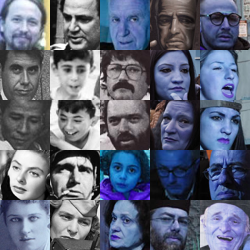

In [64]:
mosaico



---



## Método B

¡¡ IMPORTANTE !! 

***EL MÉTODO A Y EL B SON EXCLUYENTES. NO EJECUTAR SUS CELDAS AL MISMO TIEMPO***


## Clase propia "ImgNumpy"

In [67]:
%cd $path_proyecto

/content


In [68]:
%%writefile ImgNumpy.py
# Version v2.4
# Last modification: 13/12/2022
from PIL import Image

import numpy as np

from random import randint



class ImgNumpy:

  def __init__(self, name = '', W = 1, H = 1, R = 0, G = 0, B = 0):
    # En los métodos para imágenes primero va el ancho y luego el alto
    # En los arrays numpy primer va el alto y luego el ancho
    # np.zeros((height, width))
    self._array = np.zeros((H, W, 3), dtype = np.uint8)
    self._name = name
    self._height = H
    self._width = W
    self._red = R
    self._green = G
    self._blue = B
    for i in range(0, self._array.shape[0]):
      for j in range(0, self._array.shape[1]):
        self._array[i, j] = [R, G, B]
  
  # propiedad imagen: devuelve una imagen creada desde el array
  # equivale a tener una variable de instancia tipo <self._img>
  @property
  def img(self):
      return Image.fromarray(self._array) #self._img 

  # name
  @property
  def name(self):
      return self._name  

  @name.setter
  def name(self, value):
      if value.isalpha():
        self._name = value
      else:
        raise ValueError("Not a valid name.\n \
        Only alphabetic characters allowed.")

  #array
  @property
  def array(self):
    return self._array

  # Nuevo en la versión v2.3
  #-------------------------
  # array setter
  @array.setter
  def array(self, new_np_array):
    self._array = new_np_array
    self._height = new_np_array.shape[0]
    self._width = new_np_array.shape[1]
    self._red = 0
    self._green = 0
    self._blue = 0
    #-------------------------

  # height
  @property
  def height(self):
      return self._height

  @height.setter
  def height(self, value):
    img = self.img
    img = img.resize((self._width, value))
    self._array = np.asarray(img)
    self._height = value

  # width
  @property
  def width(self):
      return self._width

  @width.setter
  def width(self, value):
    img = self.img
    img = img.resize((value, self._height))
    self._array = np.asarray(img)        
    self._width = value

  # red
  @property
  def red(self):
      return self._red

  @red.setter
  def red(self, value):
        self._red = value
        new_arr = self._array.copy()
        for i in range(0, self._array.shape[0]):
          for j in range(0, self._array.shape[1]):
            # self._array[i, j] = [value, self._green, self._blue]
            new_arr[i, j] = [value, self._green, self._blue]
        self._array = new_arr
  
  # green
  @property
  def green(self):
      return self._green

  @green.setter
  def green(self, value):
        self._green = value
        new_arr = self._array.copy()
        for i in range(0, self._array.shape[0]):
          for j in range(0, self._array.shape[1]):
            new_arr[i, j] = [self._red, value, self._blue]
        self._array = new_arr

  # blue
  @property
  def blue(self):
      return self._blue

  @blue.setter
  def blue(self, value):
        self._blue = value
        new_arr = self._array.copy()
        for i in range(0, self._array.shape[0]):
          for j in range(0, self._array.shape[1]):
            new_arr[i, j] = [self._red, self._green, value]
        self._array = new_arr 

  # About image info
  #-----------------------------------------------------------
  def get_img_format(self):
    img = Image.fromarray(self._array)
    return img.format

  def get_img_format_desc(self):
    img = Image.fromarray(self._array)
    return img.format_description

  def get_img_size(self):
    img = Image.fromarray(self._array)
    return img.size

  def get_img_mode(self):
    img = Image.fromarray(self._array)
    return img.mode

  def get_img_info(self):
    img = Image.fromarray(self._array)
    return (img.format, img.format_description, img.size, img.mode) 
    return print("\nFormat: ", img.format,
              "\nFormat Description: ", img.format_description,
              "\nSize: ", img.size, 
              "\nMode: ", img.mode)

  #-----------------------------------------------------------

  # Devuelve información sobre las
  # variables del objeto
  def print_info(self):
    return print("\nNombre: ", self._name,
                 "\nAncho: ", self._width,
                 "\nAlto: ", self._height, 
                 "\nColor rojo: ", self._red,
                 "\nColor verde: ", self._green,
                 "\nColor azul: ", self._blue)
  
  # Devuelve el shape del array
  def get_ndim(self):
    return self._array.ndim

  # Devuelve el shape del array    
  def get_itemsize(self):
    return self._array.itemsize

  # Devuelve el shape del array
  def get_size(self):
    return self._array.size
  
  # Devuelve el shape del array
  def get_shape(self):
    return self._array.shape

  # Exercise's methods:
  # -------------------

  # c.) Redimensiona la imagen

  def resize(self, width, height):
    # resize(width, height)
    img = self.img
    img = img.resize((width, height))
    self._array = np.asarray(img)        
    self._height = height        
    self._width = width

  # ------------------------------------------------------------------------

  # d.) Redimensiona el ancho dejando el mismo alto
  
  def resize_w(self, new_width):
    # resize(width, height)
    img = Image.fromarray(self._array)
    img = img.resize((new_width, self._height))
    self._array = np.asarray(img)              
    self._width = new_width     

  # ------------------------------------------------------------------------

  # e.) Redimensiona el alto dejando el mismo ancho
 
  def resize_h(self, new_height):
    # resize(width, height)
    img = Image.fromarray(self._array)
    img = img.resize((self._width, new_height))
    self._array = np.asarray(img)              
    self._height = new_height 

  # ------------------------------------------------------------------------

  # f.) Implementa un método que devuelva un trozo de una imagen 
  # especificando la posición horizontal y vertical y el ancho y el alto,
  # si las dimensiones especificadas son superiores a la
  # imagen original, debe devolver el recorte disponible.

  # Opción A
  
  def cropped(self, x_start, y_start, x_end, y_end):
    img = Image.fromarray(self._array)
    cropped = Image.fromarray(self._array)
    if ( 
        ( x_start < x_end ) and
        ( y_start < y_end ) and
        ( x_start + x_end < img.size[0] ) and
        ( y_start + y_end < img.size[1] ) 
      ):
      tuple_params = (x_start, y_start, x_end, y_end)
      cropped = img.crop(tuple_params)
    else: 
      raise ValueError("Incorrect input values")
    return cropped

  # ........................................................................
  
  # f.)
  
  # Opción B
  
  def slice_image(self, X_start=0, Y_start=0, X_end=10, Y_end=10):
    result = Image.fromarray(self._array)
    if  ( X_start < self._width ) and ( Y_start < self._height ):
      if ( X_end + X_start ) < self._width: last_x = X_end + X_start
      else: last_x = self._width
      if ( Y_end + Y_start ) < self._height: last_y = Y_end + Y_start
      else: last_y = self._height
      result = Image.fromarray(self._array[Y_start:last_y, X_start:last_x])
    return result
     
  
  # ------------------------------------------------------------------------

  # g.) Implementa un método que apile dos imágenes horizontal o verticalmente,
  # sin deformarlas. El método debe especificar en sus argumentos qué 
  # dimensiones son las que se deben adaptar. 

  # Opción A

  # This method returns a new image stacked vertically
  # or horizontally according to "position" parameter
  # First parameter: object class ImgNumpy
  # Second parameter: string of value "horizontal" or "vertical"
  def create_stacked_img(self, image, position="vertical"):
    image_result = Image.fromarray(self._array) 
    if position == "vertical":
      image.resize_w(self._width)
      image1 = Image.fromarray(self._array)
      image2 = Image.fromarray(image.array)
      array = np.vstack([image1, image2])
      image_result = Image.fromarray(array)
    elif position == "horizontal":
      image.resize_h(self._height)
      image1 = Image.fromarray(self._array)
      image2 = Image.fromarray(image.array)
      array = np.hstack([image1, image2])
      image_result = Image.fromarray(array)
      pass
    else:
      raise ValueError("Wrong position input") 
    return image_result      
  
  # ........................................................................
  
  # h.)
  # Implementa un método que apile dos imágenes horizontal o  verticalmente, 
  # si las dimensiones de las imágenes no coinciden, debe adaptarlas a la imagen 
  # más ancha o más alta, deformándolas si fuera necesario
  
  def stack_images_deforming(self, img, position = "vertical"):
    result = self.img
    if ( position == "horizontal" ):
      if ( self._height > img.height ): 
        result = self.create_stacked_img(img, "horizontal")
      else:
        result = img.create_stacked_img(self, "horizontal")
    elif ( position == "vertical" ):
      if ( self._width > img.width ): 
        result = self.create_stacked_img(img, "vertical")
      else:
        result = img.create_stacked_img(self, "vertical")    
    else: raise ValueError("Wrong position")
    return result

  # ------------------------------------------------------------------------

  # i.)
  # Implementa un método que inserte una imagen dentro de otra imagen en la 
  # posición horizontal y vertical especificada. 
  # Si la imagen que se va a insertar no cabe entera, debe recortarla.

  # Ejemplo: La primera imagen se inserta en dos imágenes diferentes.
  # En la primera imagen, la posición de inserción especificada no permite 
  # insertar la imágen completa. 
  
  # En la segunda imagen, la posición de inserción permite insertar la 
  # imagen de forma completa.
  def insert_image_force(self, img, x=1, y=1):
    output = self.img
    if ( x >= 0) and  ( y >= 0):
      arr_a = np.copy(self._array)
      arr_b = np.copy(img.array)
      shape_x_a = x + arr_b.shape[0]
      shape_y_a = y + arr_b.shape[1]
      shape_x_b = arr_a.shape[0] - x
      shape_y_b = arr_a.shape[1] - y
      if(shape_x_a > arr_a.shape[0]): shape_x_a = arr_a.shape[0]
      if(shape_y_a > arr_a.shape[1]): shape_y_a = arr_a.shape[1]
      arr_a[x:shape_x_a,y:shape_y_a] = arr_b[0:shape_x_b,0:shape_y_b]
      output = Image.fromarray(arr_a)
    else:
        raise ValueError("Wrong (x, y) inputs")    
    return output

  # ------------------------------------------------------------------------

  # j.)
  # Implementa un método que inserte dentro de una imagen otra imagen
  # en la posición horizontal y vertical especificada con el ancho y el
  # alto especificado. Si la imagen que se vaa insertar no cabe entera,
  # debe recortarla
  def insert_image_redim(self, img, x, y, width, height):
    img_copy = img
    img_copy.width = width
    img_copy.height = height
    return self.insert_image_force(img_copy, x, y)

  # ------------------------------------------------------------------------

  # k.)
  # Implementa un método al que se le pasa el número de elementos horizontales y
  # verticales, así como el ancho y el alto de los elementos horizontales y 
  # verticales y que devuelva la imagen creada con un color de fondo diferente 
  # para cada elemento.

  # Ejemplo: 

  # Imagen con 8 por 8 elementos del mismo ancho y alto e imagen 
  # con 8 por 3 elementos con diferente ancho y alto.
  @staticmethod
  def mosaic(x = 10, y = 10, width = 10, height = 10):
    total_width = x * width
    total_height = y * height
    _data = np.zeros((total_height, total_width, 3), dtype = np.uint8)
    for i in range(0, total_width, width):
        for j in range(0, total_height, height):
            _data[j : j + height, i : i + width] = \
                      (randint(0, 255), randint(0, 255), randint(0, 255))
    return Image.fromarray(_data)

# ------------------------------------------------------------------------

  # Nuevo método: cargar una imagen desde un archivo en nuestro objeto
  # tomamos una imagen. La descomponemos y cambiamos los atributos de 
  # nuestro objeto para que imiten a la imagen.
  def adopt_img_from_file(self, img):
    self._array = np.asarray(img)
    self._height = img.height 
    self._width = img.width
    self._red = 0
    self._green = 0
    self._blue = 0   


# ------------------------------------------------------------------------
# MÉTODO ESTÁTICO
# ------------------------------------------------------------------------
#  Versión estática de 'create_stacked_img'
  
  # This method returns a new image stacked vertically
  # or horizontally according to "position" parameter
  # First and seconds parameters: PIP.Image.Image class
  # Third parameter: string of value "horizontal" or "vertical"
  @staticmethod
  def create_stacked_img_static(img1, img2, position="vertical"):
    image_result = img1
    i = Image.new("RGB", (1,1))
    # Comprobamos que "img1" e "img2" son de la clase 'PIL.Image.Image'
    if (isinstance(img1, (type(i)))) and (isinstance(img2, (type(i)))):
      # Tratamos de unificar el modo de color de las imágenes
      # Sólo trabajamos con el tipo RGB así que intentamos convertir
      # las imágenes de entrada a este formato
      if img1.mode != "RGB":
        try:
          img1 = img1.convert("RGB")
        except ValueError as err:
          print(f"Conversión no permitida {err}, {type(err)}")
        except Exception as err:
          print(f"Error indeterminado {err}, {type(err)}")
          raise
      else: pass
      if img2.mode != "RGB":
        try:
          img2 = img2.convert("RGB")
        except ValueError as err:
          print(f"Conversión no permitida {err}, {type(err)}")
        except Exception as err:
          print(f"Error indeterminado {err}, {type(err)}")
          raise
      else: pass              
      # Comprobación del parámetro de tipo de apilamiento
      if position == "vertical":
        # Se adapta el ancho de la segunda imagen al de la primera
        img2 = img2.resize((img1.width, img2.height))
        image_result = Image.fromarray(np.vstack((np.asarray(img1), np.asarray(img2))))
      elif position == "horizontal":
        # Se adapta el alto de la segunda imagen al de la primera
        img2 = img2.resize((img2.width, img1.height))
        image_result = Image.fromarray(np.hstack((np.asarray(img1), np.asarray(img2))))
      else:
        raise ValueError("Wrong position inputs")
    else:
      raise AttributeError("img1 or img1 are not 'PIL.Image.Image' classes")
    return image_result

  # ------------------------------------------------------------------------

  # Crear un mosaico a partir de una LISTA de arrays Numpy que
  # Número de imágenes Numpy en la lista: doce
  # Dimensiones del mosaico: ancho >> 4 imágenes; alto >> 3 imágenes
  def mosaic_from_imgs(self, list_of_imgs):
    x = 10
    y = 10

    width = list_of_imgs[0].shape[1] 
    height = list_of_imgs[0].shape[0]
    index = 0 

    total_height = y * height
    total_width = x * width

    frame = np.zeros((total_height, total_width, 3), dtype = np.uint8)

    for i in range(0, total_width, width):
        for j in range(0, total_height, height):
            frame[j : j + height, i : i + width] = list_of_imgs[index].copy() 
            index += 1

    self._array = frame
    self._height = total_height 
    self._width = total_width
    self._red = 0
    self._green = 0
    self._blue = 0       

Overwriting ImgNumpy.py


In [69]:
# Cargamos la clase "ImgNumpy"
sys.path.append('$path_proyecto')

import ImgNumpy as iny

### Utilización de la clase propira "ImgNumpy" para realizar operaciones

In [70]:
ALTO, ANCHO = 50, 50

In [72]:
my_class_list = list()
for k in range(len(images_cropped)):
    if k < 10: imagen = iny.ImgNumpy('img0'+str(k))
    else: imagen = iny.ImgNumpy('img'+str(k))
    imagen.array = images_cropped[k]
    imagen.resize(ANCHO, ALTO)
    my_class_list.append(imagen)

In [ ]:
#Lista de clases. Cada una contiene una imagen con un rostro
for obj in my_class_list:
    print(obj.name)

img00
img01
img02
img03
img04
img05
img06
img07
img08
img09
img10
img11
img12
img13
img14
img15
img16
img17
img18
img19
img20
img21
img22
img23
img24
img25
img26
img27
img28
img29
img30
img31
img32
img33
img34
img35
img36
img37
img38
img39


## Apilar las imágenes

El mosaico realizado es de 3 filas por 4 columnas. En total 12 imágenes.

In [73]:
if len(my_class_list) >= 12:
    stackedh1 = iny.ImgNumpy('stackedh1')
    stackedh2 = iny.ImgNumpy('stackedh2')
    stackedh3 = iny.ImgNumpy('stackedh3')
    stackedh4 = iny.ImgNumpy('stackedh4')
    stackedh5 = iny.ImgNumpy('stackedh5')
    stackedh1 = my_class_list[0].create_stacked_img(my_class_list[1], 'horizontal')
    stackedh2= my_class_list[2].create_stacked_img(my_class_list[3], 'horizontal')
    stackedh3.adopt_img_from_file(stackedh1)
    stackedh4.adopt_img_from_file(stackedh2)
    stackedh5.adopt_img_from_file(stackedh3.create_stacked_img(stackedh4, 'horizontal'))
    stackedv1 = iny.ImgNumpy('stackedv1')
    stackedv2 = iny.ImgNumpy('stackedv2')
    stackedv3 = iny.ImgNumpy('stackedv3')
    stackedv4 = iny.ImgNumpy('stackedv4')
    stackedv1.adopt_img_from_file(my_class_list[4].create_stacked_img(my_class_list[5], 'vertical'))
    stackedv2.adopt_img_from_file(my_class_list[6].create_stacked_img(my_class_list[7], 'vertical'))
    stackedv3.adopt_img_from_file(my_class_list[8].create_stacked_img(my_class_list[9], 'vertical'))
    stackedv4.adopt_img_from_file(my_class_list[10].create_stacked_img(my_class_list[11], 'vertical'))
    stackedh6 = iny.ImgNumpy('stackedh6')
    stackedh7 = iny.ImgNumpy('stackedh7')
    stackedh8 = iny.ImgNumpy('stackedh8')
    stackedv5 = iny.ImgNumpy('stackedv5')
    stackedh6.adopt_img_from_file(stackedv1.create_stacked_img(stackedv2, 'horizontal'))
    stackedh7.adopt_img_from_file(stackedv3.create_stacked_img(stackedv4, 'horizontal'))
    stackedh8.adopt_img_from_file(stackedh6.create_stacked_img(stackedh7, 'horizontal'))
    stackedv5.adopt_img_from_file(stackedh5.create_stacked_img(stackedh8, 'vertical'))
else:
    print("No es posible realizar el mosaico 3x4=12")

#### Resultado final

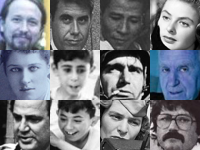

In [74]:
stackedv5.img



---

